In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from gurobipy import *
from matplotlib import pyplot as plt
import collections
from copy import *
from IPython.display import HTML
from IPython.display import display
from collections import *

In [2]:
# 'skus' table
skus = pd.read_csv('JD_sku_data.csv')
# 'orders' table
orders = pd.read_csv('JD_order_data.csv')
# 'delivery' table
delivery = pd.read_csv('JD_delivery_data.csv')
# 'inventory' table
inventory = pd.read_csv('JD_inventory_data.csv')
# 'network' table
network = pd.read_csv('JD_network_data.csv')

# Data Processing

We consider one region as instance

In [3]:
sample_dcs = sorted(network[network['region_ID'] == 3]['dc_ID'].tolist())
sample_dcs

[3, 14, 33, 34, 35, 64]

In [4]:
orders_in_sample_dcs = orders[(orders['dc_des'].isin(sample_dcs)) & (orders['order_date'] <= '2018-03-31')]

In [5]:
skus_in_sample_dcs = orders_in_sample_dcs.groupby('sku_ID').count()['order_ID'].to_dict()

We present SKUs which are out of inventory

In [6]:
no_inventory = defaultdict(list)
for dc in sample_dcs:
    for sku in skus_in_sample_dcs:
        if len(inventory[(inventory['dc_ID'] == dc) & (inventory['sku_ID'] == sku)]) == 0:
            no_inventory[dc].append(sku)

In [7]:
np.mean(orders_in_sample_dcs[orders_in_sample_dcs['sku_ID'].isin(no_inventory[3])].groupby('sku_ID').count()['order_ID'])

7.6503875968992245

In [8]:
len(orders_in_sample_dcs)
#len(skus_in_sample_dcs)

33606

In [9]:
np.mean([len(no_inventory[i]) for i in sample_dcs[1:]])

2745.0

We present fulfillment details

In [10]:
orders_fulfill_region = orders_in_sample_dcs[(orders_in_sample_dcs['dc_ori'].isin(sample_dcs)) & (orders_in_sample_dcs['dc_des'].isin(sample_dcs))]

In [11]:
orders_fulfill_local = orders_fulfill_region[(orders_fulfill_region['dc_ori'] == orders_fulfill_region['dc_des'])]

In [12]:
orders_fulfill_backup = orders_fulfill_region[(orders_fulfill_region['dc_ori'] == 3) & (orders_fulfill_region['dc_des'] != 3)]

In [13]:
len(orders_fulfill_region), len(orders_fulfill_local), len(orders_fulfill_backup)

(13002, 5877, 6525)

We start with SKUs in small scale

In [540]:
sample_skus = [k for k, v in skus_in_sample_dcs.items() if 4000 >= v >= 800 or 200 >= v >= 180 or 40 >= v >= 38]

We can also consider those SKUs fulfilled within the region in large scale

In [11]:
sample_skus = [k for k, v in skus_in_sample_dcs.items() if k not in no_inventory[3]]

We choose top SKUs 

In [42]:
demand_over_skus = orders_in_sample_dcs.groupby('sku_ID').count()['order_ID'].to_dict()
sample_skus = [i for i, j in sorted(demand_over_skus.items(), key = lambda kv: kv[1], reverse=True)]
sample_skus = sample_skus[:200]

In [43]:
sample_orders = orders_in_sample_dcs[orders_in_sample_dcs['sku_ID'].isin(sample_skus)]
demand_over_skus = sample_orders.groupby('sku_ID').count()['order_ID'].to_dict()
demand_over_dcs = sample_orders.groupby('dc_des').count()['order_ID'].to_dict()
sample_skus = [i for i, j in sorted(demand_over_skus.items(), key = lambda kv: kv[1], reverse=True)]

In [44]:
demand_over_skus_list = sorted(demand_over_skus.values(), reverse=True)

In [2]:
plt.plot(np.arange(1, 201), demand_over_skus_list)
plt.xticks([1] + list(np.arange(20, 201, 20)))
plt.xlabel('sku_ID')
plt.ylabel('orders')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('demand_over_skus.pdf')

NameError: name 'plt' is not defined

We analyze the demand

In [145]:
demand_dist = {}
for i in sample_dcs:
    for k in sample_skus:
        hist = []
        for d in range(1, 32):
            if d <= 9:
                date = '2018-03-0' + str(d)
            else:
                date = '2018-03-' + str(d)
            hist.append(len(sample_orders[(sample_orders['dc_des'] == i) & (sample_orders['sku_ID'] == k) & (sample_orders['order_date'] == date)]))
            
        demand_dist[i, k] = (np.mean(hist), np.std(hist))

In [48]:
sample_orders_first = sample_orders[sample_orders['order_date'] <= '2018-03-31']
demand_over_dcs_first = sample_orders_first.groupby('dc_des').count()['order_ID'].to_dict()
demand_over_skus_first = sample_orders_first.groupby('sku_ID').count()['order_ID'].to_dict()

In [49]:
demand_over_dcs = sample_orders.groupby('dc_des').count()['order_ID'].to_dict()
demand_over_dcs

{3: 2216, 14: 549, 33: 7384, 34: 4263, 35: 4131, 64: 3690}

In [50]:
local_fulfill_over_dcs = orders_fulfill_local.groupby('dc_des').count()['order_ID'].to_dict()
local_fulfill_over_dcs

{3: 427, 14: 138, 33: 2263, 34: 1095, 35: 1073, 64: 881}

In [51]:
backup_fulfill_over_dcs = orders_fulfill_backup.groupby('dc_des').count()['order_ID'].to_dict()
backup_fulfill_over_dcs[3] = 0
backup_fulfill_over_dcs

{14: 175, 33: 2326, 34: 1418, 35: 1360, 64: 1246, 3: 0}

In [52]:
region_fulfill_over_dcs = orders_fulfill_region.groupby('dc_des').count()['order_ID'].to_dict()
flex_fulfill_over_dcs, cross_fulfill_over_dcs = {}, {}
for i in sample_dcs:
    flex_fulfill_over_dcs[i] = region_fulfill_over_dcs[i] - local_fulfill_over_dcs[i] - backup_fulfill_over_dcs[i]
    cross_fulfill_over_dcs[i] = demand_over_dcs[i] - region_fulfill_over_dcs[i]

In [53]:
local = [local_fulfill_over_dcs[i] for i in sample_dcs]
backup = [backup_fulfill_over_dcs[i] for i in sample_dcs]
spillover = [flex_fulfill_over_dcs[i] + backup_fulfill_over_dcs[i] for i in sample_dcs]
cross = [cross_fulfill_over_dcs[i] for i in sample_dcs]

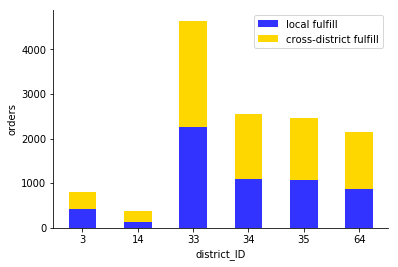

In [90]:
label_list = sample_dcs
fig, ax = plt.subplots()
plt.bar(x=range(len(sample_dcs)), height=local, width=0.5, alpha=0.8, color='blue', label='local fulfill')
plt.bar(x=range(len(sample_dcs)), height=spillover, width=0.5, color='gold', bottom=local, label='cross-district fulfill')
#plt.bar(x=range(len(sample_dcs)), height=cross, width=0.5, color='gold', bottom=list(region_fulfill_over_dcs.values()), label='cross-region fulfill')
plt.xticks([index for index in range(len(sample_dcs))], label_list)
plt.xlabel('district_ID')
plt.ylabel('orders')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend()
plt.savefig('fulfill_over_dcs.pdf')

We generate demand scenarios

In [55]:
total_demand_first = sum(demand_over_skus_first.values()) 
T_first = int((np.ceil(total_demand_first / 1000)) * 1000) 
sku_freq_first = []
for k in sample_skus:
    if k in demand_over_skus_first:
        sku_freq_first.append(demand_over_skus_first[k] / T_first)
    else:
        sku_freq_first.append(0)
dc_freq_first = [demand_over_dcs_first[dc] / total_demand_first for dc in sample_dcs]
multinomial_sku_first = [1 - sum(sku_freq_first)] + sku_freq_first
multinomial_dc_first = dc_freq_first

In [56]:
N = 1000
demand_scenarios = []
demand_scenarios_agg = []
T = int(T_first) 

for n in range(N):
    skus = np.random.choice(['NA'] + sample_skus, T, p=multinomial_sku_first)
    dcs = np.random.choice(sample_dcs, T, p=multinomial_dc_first)
    sample = list(zip(skus, dcs))
    
#     skus = np.random.choice(['NA'] + sample_skus, T_second, p=multinomial_sku_second)
#     dcs = np.random.choice(sample_dcs, T, p=multinomial_dc_second)
#     sample_second = list(zip(skus, dcs))   
    
#     sample = sample + sample_second
    
    demand_scenarios.append(sample)

#     D = {}
#     for i in sample_dcs:
#         for k in sample_skus:
#             D[k, i] = max(int(sum(np.random.normal(demand_dist[i, k][0], demand_dist[i, k][1], 7))), 0)
#     demand_scenarios_agg.append(D)

expected = {}
for k in range(len(sku_freq_first)):
    for i in range(len(dc_freq_first)):
        expected[sample_skus[k], sample_dcs[i]] = T * sku_freq_first[k] * dc_freq_first[i]
        
# for i in sample_dcs:
#     for k in sample_skus:
#         expected[k, i] = demand_dist[i, k][0] * 7

We can also consider a special case 

In [457]:
# sample_dcs = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
# sample_skus = [i for i in range(1, 9)]

sample_dcs = ['A', 'B', 'C', 'D']
sample_skus = [i for i in range(1, 9)]

In [459]:
N = 1000

# T = 400
# demand_scenarios = []
# sku_freq = [1/len(sample_skus)] * len(sample_skus)
# dc_freq = [1/len(sample_dcs)] * len(sample_dcs)

# for n in range(N):
#     skus = np.random.choice(sample_skus, T, p=sku_freq)
#     dcs = np.random.choice(sample_dcs, T, p=dc_freq)
#     sample = list(zip(skus, dcs))
#     demand_scenarios.append(sample)
    
# expected = {}
# for k in range(len(sku_freq)):
#     for i in range(len(dc_freq)):
#         expected[sample_skus[k], sample_dcs[i]] = T * sku_freq[k] * dc_freq[i]
    
    
demand_scenarios = []
sku_mean = np.arange(100, 120, 0.1)[::-1]
sku_std = np.arange(0, 50, 5)[::-1]
dc_freq = [1/len(sample_dcs)] * len(sample_dcs)

for n in range(N):
    skus = []
    for k in sample_skus:
        skus += [k] * int(max(0, np.random.normal(sku_mean[sample_skus.index(k)], sku_std[sample_skus.index(k)])))
    skus = np.random.permutation(skus)    
        
    dcs = np.random.choice(sample_dcs, len(skus), p=dc_freq)
    sample = list(zip(skus, dcs))
    demand_scenarios.append(sample)  
    
expected = {}
for k in range(len(sample_skus)):
    for i in range(len(sample_dcs)):
        expected[sample_skus[k], sample_dcs[i]] = sku_mean[k] * dc_freq[i]

## Model Formulation

In [58]:
def optimize(S, D): 
    model = Model('model')
    model.setParam("LogToConsole", 0)

    fulfill = model.addVars(((k, i, j) for k in sample_skus for i in supply for j in demand), vtype=GRB.CONTINUOUS, name='fulfill')

    model.setObjective(sum(fulfill[k, i, j] * cost[k, i, j] for k, i, j in fulfill), GRB.MINIMIZE)

    for k in sample_skus:
        for i in supply:
            model.addConstr(fulfill.sum(k, i, '*') <= S[k, i], name='supply_%s_%s' % (k, i))

        for j in demand:
            model.addConstr(fulfill.sum(k, '*', j) == D[k, j], name='demand_%s_%s' % (k, j))

    model.optimize()
    
    return model, fulfill

def optimize_k(k, S, D): 
    model = Model('model_1')
    model.setParam("LogToConsole", 0)

    fulfill = model.addVars([(i, j) for i in supply for j in demand], vtype=GRB.CONTINUOUS, name='fulfill_1')

    model.setObjective(sum(fulfill[i, j] * cost[k, i, j] for i, j in fulfill), GRB.MINIMIZE)

    for i in supply:
        model.addConstr(sum(fulfill[i, j] for j in demand) <= S[k, i])

    for j in demand:
        model.addConstr(sum(fulfill[i, j] for i in supply) == D[k, j])

    model.optimize()
    
    return model, fulfill

def misp_k(k, S_init, D, _lambda, regu, critical): 
    model = Model()
    model.setParam("LogToConsole", 0)

    #Z = model.addVars([i for i in supply[1:]], vtype=GRB.BINARY, name='indicator')
    Z = model.addVars([i for i in supply[1:]], vtype=GRB.CONTINUOUS, name='penalty')
    #Z = model.addVar(vtype=GRB.BINARY, name='indicator')
    S = model.addVars([i for i in supply], vtype=GRB.CONTINUOUS, name='inventory')
    F = model.addVars([(m, i, j) for m in range(len(D)) for i in supply for j in demand], vtype=GRB.CONTINUOUS, name='fulfill')
    
    allocation_cost = sum(S[i] * b for i in supply[1:])
    fulfill_cost = sum(F[m, i, j] * cost[k, i, j] for m in range(len(D)) for i in supply for j in demand) / len(D)
    penalty_cost = _lambda * sum(Z[i] for i in supply[1:])
    #penalty_cost = _lambda * Z
    
    model.setObjective(allocation_cost + fulfill_cost + penalty_cost, GRB.MINIMIZE)

    model.addConstr(S[0] == 10000)
#     for i in supply[1:]:
#         if i not in dc:
#             model.addConstr(S[i] == S_init[k, i])
    
    for m in range(len(D)):
        for i in supply:
            model.addConstr(F.sum(m, i, '*') <= S[i])

        for j in demand:
            model.addConstr(F.sum(m, '*', j) == D[m][j])
            
    for i in supply[1:]:
        #model.addConstr(S[i] <= 1000 * Z[i])
        model.addConstr(Z[i] == min_(S[i], critical[i]))
        
    #model.addConstr(sum(S[i] for i in supply[1:]) <= 10000 * Z)
        
    model.optimize()
    
    S_k = model.getAttr('X', S)
    #Z_k = model.getAttr('X', Z)
    
    return S_k

def assort_misp_k(k, D, _lambda): 
    model = Model()
    model.setParam("LogToConsole", 0)

    Z = model.addVar(vtype=GRB.BINARY, name='indicator')
    S = model.addVars([i for i in supply], vtype=GRB.CONTINUOUS, name='inventory')
    F = model.addVars([(m, i, j) for m in range(len(D)) for i in supply for j in demand], vtype=GRB.CONTINUOUS, name='fulfill')
    
    allocation_cost = sum(S[i] * b for i in supply[1:])
    fulfill_cost = sum(F[m, i, j] * cost[k, i, j] for m in range(len(D)) for i in supply for j in demand) / len(D)
    penalty_cost = _lambda * Z
    
    model.setObjective(allocation_cost + fulfill_cost + penalty_cost, GRB.MINIMIZE)

    model.addConstr(S[0] == 10000)
    
    for m in range(len(D)):
        for i in supply:
            model.addConstr(F.sum(m, i, '*') <= S[i])

        for j in demand:
            model.addConstr(F.sum(m, '*', j) == D[m][j])
                 
    model.addConstr(sum(S[i] for i in supply[1:]) <= 10000 * Z)
        
    model.optimize()
    
    S_k = model.getAttr('X', S)
    #Z_k = model.getAttr('X', Z)
    
    return S_k

We set up parameters

In [67]:
b = 1

supply = [0] + sample_dcs
demand = sample_dcs
cost = {}
for k in sample_skus:
    for j in demand:
        for i in supply:              
            if i == 0:
                cost[k, i, j] = np.random.normal(10, 0)
            else:
#                 shortest = min(abs(sample_dcs.index(j) - sample_dcs.index(i)), len(sample_dcs) - abs(sample_dcs.index(j) - sample_dcs.index(i)))
#                 if shortest == 0:
#                     cost[k, i, j] = 2
#                 elif shortest == 1:
#                     cost[k, i, j] = 3
#                 elif shortest == 2:
#                     cost[k, i, j] = 4
#                 elif shortest == 3:
#                     cost[k, i, j] = 5
#                 elif shortest == 4:
#                     cost[k, i, j] = 6

                if i == j:
                    cost[k, i, j] = np.random.normal(2, 0)
                elif i == sample_dcs[0]:
                    cost[k, i, j] = np.random.normal(5, 0)
                elif (i, j) in [(33, 34), (34, 35), (35, 64), (64, 33)]:    
                    cost[k, i, j] = np.random.normal(4, 0)
                else:
                    cost[k, i, j] = np.random.normal(6, 0)
            


We optimize inventory allocation with cardinality constraints

In [61]:
def greedy_projection(S, Delta):  
    model = Model('projection')
    model.setParam("LogToConsole", 0)
    transfer = model.addVars([(k, i, j) for k in sample_skus for i in supply for j in supply[1:]], vtype=GRB.CONTINUOUS, ub=1, name='transfer')
    empty = model.addVars([(k, j) for k in sample_skus for j in supply[1:]], vtype=GRB.BINARY, name='empty')   
        
    loss = 0
    for k in sample_skus:
        for i in supply:
            for j in supply[1:]:
                loss += transfer[k, i, j] * Delta[k, i, j] 
        
    model.setObjective(loss, GRB.MINIMIZE)

    for j in supply[1:]:
        model.addConstr(sum(empty[k, j] for k in sample_skus) >= len(sample_skus) - card[j])

        for k in sample_skus:
            model.addConstr(sum(transfer[k, i, j] for i in supply) >= empty[k, j])
            model.addConstr(sum(transfer[k, i, j] for i in supply) <= 1)

        for k in sample_skus:
            for i in supply[1:]:
                model.addConstr(transfer[k, j, i] <= 1 - empty[k, j])
                
        q = 0
        for k in sample_skus:
            q += S[k, j] * (1 - sum(transfer[k, i, j] for i in supply))
            for i in supply[1:]:
                q += S[k, i] * transfer[k, j, i]
        
        model.addConstr(q <= unit[j])

    model.optimize()
    
    return model, transfer, empty

In [81]:
card, unit = {}, {}
for i in supply[1:]:
    if i == sample_dcs[0]:
        card[i] = 200
        unit[i] = 10000
    else:
        card[i] = 200
        unit[i] = 2000
        
S_init = defaultdict(float)

for k in sample_skus:
    S_init[k, 0] = 1e8 
    for i in supply[1:]:
        S_init[k, i] = int(expected[k, i])
        #S_init[k, i] = 0

In [82]:
S_init = solve_allocation(M=1, rho=0, assort=True)
# solve_allocation_coordinate(False)

3 [164, 133, 111, 112, 93, 97, 96, 93, 93, 79, 84, 87, 85, 86, 86, 82, 79, 79, 75, 70, 72, 68, 74, 76, 72, 76, 75, 64, 66, 70, 70, 66, 69, 67, 69, 71, 73, 62, 69, 68, 70, 60, 61, 68, 70, 68, 65, 64, 60, 57, 57, 63, 65, 57, 58, 58, 57, 61, 61, 60, 55, 54, 57, 54, 53, 62, 60, 58, 51, 49, 58, 53, 58, 50, 55, 50, 50, 54, 49, 56, 56, 54, 57, 52, 58, 47, 55, 53, 49, 45, 50, 53, 51, 47, 47, 49, 49, 46, 50, 51, 50, 48, 47, 49, 46, 44, 44, 46, 45, 45, 46, 47, 44, 46, 44, 46, 45, 47, 46, 46, 43, 46, 43, 42, 41, 39, 39, 41, 39, 40, 41, 40, 38, 39, 38, 37, 37, 37, 33, 36, 36, 34, 34, 33, 33, 33, 34, 32, 30, 29, 30, 29, 29, 28, 26, 28, 29, 27, 28, 26, 25, 26, 25, 25, 25, 25, 25, 26, 25, 26, 27, 23, 24, 25, 24, 24, 23, 23, 22, 22, 23, 23, 22, 23, 22, 20, 22, 20, 23, 20, 21, 21, 22, 18, 21, 20, 22, 20, 20, 21]
14 [44, 36, 29, 33, 23, 18, 27, 24, 24, 28, 27, 17, 19, 22, 16, 20, 20, 19, 19, 13, 19, 18, 18, 20, 21, 12, 21, 18, 21, 16, 20, 13, 15, 22, 19, 16, 19, 17, 20, 16, 16, 16, 17, 16, 9, 12, 14, 14

In [83]:
def solve_allocation_coordinate(assort=True):
    for tau in range(3):
        for k in sample_skus:
            D = []
            for _iter in range(200):
                sample_path = demand_scenarios[_iter]
                D_ins = collections.defaultdict(int)
                for pair in sample_path:
                    if k == pair[0]:
                        D_ins[pair[1]] += 1
                D.append(D_ins)  

            card_tmp = {i:0 for i in sample_dcs}
            for i in sample_dcs:
                for l in sample_skus:
                    if l != k and S_init[l, i] > 0:
                        card_tmp[i] += 1

            regu = {}
            for i in sample_dcs:
                if card[i] - 1 - card_tmp[i] >= 0:
                    regu[i] = 0
                else:
                    regu[i] = 1

            critical = {}
            for i in sample_dcs:
                position = [S_init[l, i] for l in sample_skus if l != k]
                if card[i] < len(sample_skus):
                    critical[i] = sorted(position, reverse=True)[card[i]-1]
                else:
                    crtitcal[i] = 0
            
            if assort:
                _lambda = 800
                S_k = assort_misp_k(k, D, _lambda)
                
                for i in sample_dcs:
                    S_init[k, i] = S_k[i]
                    
            elif sum(S_init[k, i] for i in sample_dcs) > 0:
                _lambda = 7
                S_k = misp_k(k, S_init, D, _lambda, regu, critical)

                for i in sample_dcs:
                    S_init[k, i] = S_k[i]
                
        for i in supply[1:]:
            res = []
            for k in sample_skus:
                res.append(int(S_init[k, i]))
            print(i, res)
        print('------------------')

In [84]:
def solve_allocation(M, rho, assort=True):
    for m in range(M):
        # update S_init given rho
        for loop in range(1):
#             _empty = defaultdict(int)
#             if assort:
#                 if m > 0:
#                     model, transfer, empty = greedy_projection(S_init, delta)
#                     _empty, _transfer = model.getAttr('X', empty), model.getAttr('X', transfer) 

#             else:
#                 for i in supply[1:]:
#                     small_index = np.argsort([S_init[k, i] for k in sample_skus])[:len(sample_skus)-card[i]]
#                     small_k = [sample_skus[idx] for idx in small_index]
#                     for k in small_k:
#                         _empty[k, i] = 1   

            ## update linear approximation
            sub_grad = defaultdict(float)
#             for i in supply[1:]:
#                 for k in sample_skus:
#                     sub_grad[i, k] = _empty[k, i] * rho

            ## update S_init given the convex relaxation 
            solutions = defaultdict(int)
            delta = defaultdict(float)
            for _iter in range(400):
                sample_path = demand_scenarios[_iter]
                D = collections.defaultdict(int)
                for pair in sample_path:
                    k, i = pair[0], pair[1]
                    D[k, i] += 1

                if _iter == 0:
                    model, fulfill = optimize(S_init, D)
                    _fulfill = model.getAttr('X', fulfill)
                else:
                    for k in sample_skus:
                        for j in demand:
                            name = 'demand_' + str(k) + '_' + str(j)
                            constr = model.getConstrByName(name)
                            constr.setAttr(GRB.Attr.RHS, D[k, j])
                        for i in supply[1:]:
                            name = 'supply_' + str(k) + '_' + str(i)
                            constr = model.getConstrByName(name)
                            constr.setAttr(GRB.Attr.RHS, S_init[k, i])
    
                    model.update()
                    model.optimize()

#                 if _iter >= 0:
#                     ## fulfillment cost
#                     for k in sample_skus:             
#                         for i in supply:
#                             for j in supply[1:]:
#                                 fc = sum(_fulfill[k, j, l] * (cost[k, i, l] - cost[k, j, l]) for l in demand) 
#                                 if i == 0 and j != 0:
#                                     ac = 0 - S_init[k, j] * b 
#                                     delta[k, i, j] += (fc + ac)
#                                 else: 
#                                     delta[k, i, j] += fc

                ## update capacity
                size = defaultdict(int)
                eta = 3 / (np.sqrt(_iter + 1))
                dual, grad = {}, {}   
                for i in supply[1:]:
                    for k in sample_skus: 
                        name = 'supply_' + str(k) + '_' + str(i)
                        dual[(k, i)] = model.getConstrByName(name).Pi
                        grad[k, i] = dual[k, i] + b + sub_grad[i, k]

                        S_init[k, i] = max(0, S_init[k, i] - eta * grad[k, i])
                        size[i] += S_init[k, i]

                ## projection to L-1 norm
                for i in supply[1:]:

                    if size[i] > unit[i]:
                        mu = sorted([S_init[k, i] for k in sample_skus], reverse=True)
                        largest_idx = 0
                        for l in range(len(mu)):
                            if mu[l] - (sum(mu[:l+1]) - unit[i]) / (l+1) > 0:
                                largest_idx = l
                            else:
                                break
                        theta = (sum(mu[:largest_idx+1]) - unit[i]) / (largest_idx+1)
                        for k in sample_skus:
                            S_init[k, i] = max(S_init[k, i] - theta, 0)
                         
                    for k in sample_skus:    
                        solutions[k, i] += S_init[k, i]   

            for k in sample_skus:
                for j in supply[1:]:
                    S_init[k, j] = int(solutions[k, j] / 400)
                    for i in supply:
                        delta[k, i, j] = int(delta[k, i, j] / 400)

            for i in supply[1:]:
                res = []
                for k in sample_skus:
                    res.append(S_init[k, i])
                print(i, res)
            print('------------------')

    #     # update rho given S_init
    #     kappa = 0.01
    #     delta = {}
    #     for i in supply[1:]:
    #         delta[i] = kappa * sum(sorted([S_init[k, i] for k in sample_skus])[:len(sample_skus)-card[i]]) 

#         rho += 1
#         print(rho)
    return S_init

In [85]:
allocation = []
for i in supply[1:]:
    res = []
    for k in sample_skus:
        if int(S_init[k, i]) <= 0:
            Q = 0
            S_init[k, i] = 0
        else:
            Q = int(S_init[k, i])
        res.append(Q)
    allocation.append(res)
allocation = np.array(allocation)

In [86]:
allocation

array([[164, 133, 111, ...,  20,  20,  21],
       [ 44,  36,  29, ...,   4,   4,   3],
       [321, 226, 150, ...,   0,   0,   0],
       [191, 136,  94, ...,   0,   1,   0],
       [181, 130,  92, ...,   0,   0,   0],
       [166, 119,  80, ...,   1,   1,   0]])

We present the results

In [1361]:
df = pd.read_excel('300sku_quantity_v3.xlsx')
allocation = np.array(df)
for k in sample_skus:
    for i in sample_dcs:
        idx_k = sample_skus.index(k)
        idx_i = sample_dcs.index(i)
        S_init[k, i] = allocation[idx_i, idx_k]

In [658]:
import pandas as pd
df = pd.DataFrame(allocation)
df.to_excel('20sku_quantity_v2.xlsx', index=False)

We simulate online fulfillment

In [87]:
offline_value, online_value, online_value_greedy = [], [], []
offline_fulfill, online_fulfill = defaultdict(int), defaultdict(int)

np.random.seed(1234)
for _iter in range(10):    
    print('---iter ' + str(_iter) + '---')
    sample_path = demand_scenarios[_iter]
    
    #offline
    D = collections.defaultdict(int)
    for pair in sample_path:
        k, j = pair[0], pair[1]
        D[k, j] += 1

    #D = demand_scenarios_agg[_iter]
    model, fulfill = optimize(S_init, D)
    offline_value.append(model.getAttr('objVal'))
        
    print(offline_value[_iter])
    
    # online 
    obj_bayes = 0
    obj_greedy = 0
    S_bayes = deepcopy(S_init)
    S_greedy = deepcopy(S_init)
    count = 0
    for t in range(T):                               
        if t % 20 == 0:
            D = collections.defaultdict(int)
            for k in sample_skus:
                for j in sample_dcs:
                    D[k, j] = (T-t) * sku_freq_first[sample_skus.index(k)] * dc_freq_first[sample_dcs.index(j)]
            
            for k in sample_skus:
                for j in demand:
                    name = 'demand_' + str(k) + '_' + str(j)
                    constr = model.getConstrByName(name)
                    constr.setAttr(GRB.Attr.RHS, D[k, j])
                for i in supply[1:]:
                    name = 'supply_' + str(k) + '_' + str(i)
                    constr = model.getConstrByName(name)
                    constr.setAttr(GRB.Attr.RHS, S_bayes[k, i])                        

            model.update()
            model.optimize()
            _fulfill = model.getAttr('X', fulfill)

            policy = {}
            for k in sample_skus:
                for j in demand:
                    flow = sorted([(i, _fulfill[k, i, j]) for i in supply], key=lambda x:x[1], reverse=True)
                    policy[k, j] = flow[0][0]
        
        # serve demand
        d = sample_path[t]
        if d[0] != 'NA':
            count += 1
            ### greedy 
            rank = sorted([(i, cost[d[0], i, d[1]]) for i in supply if S_greedy[d[0], i] >= 1], key=lambda x:x[1])
            i = rank[0][0]
            obj_greedy += cost[d[0], i, d[1]]
            S_greedy[d[0], i] -= 1 
            
            ### bayes selector   
            i = policy[d]
            if S_bayes[d[0], i] >= 1:
                obj_bayes += cost[d[0], i, d[1]]
                S_bayes[d[0], i] -= 1
                online_fulfill[(d[0], i, d[1])] += 1
            else: 
                obj_bayes += cost[d[0], 0, d[1]]
            
    print(obj_bayes)
    print(obj_greedy)
    print(count)
    online_value.append(obj_bayes)
    online_value_greedy.append(obj_greedy)
    
#     for i in supply[1:]:
#         res = []
#         for k in sample_skus:
#             res.append(int(S_bayes[k, i]))
#         print(i, res)
#     print('------------------')

---iter 0---
96153.0
97867.0
99926.0
22216
---iter 1---
96318.0
97850.0
100141.0
22285
---iter 2---
96267.0
98143.0
100082.0
22246
---iter 3---
95591.0
97323.0
99386.0
22206
---iter 4---
96716.0
98243.0
100301.0
22274
---iter 5---
95986.0
97699.0
99734.0
22209
---iter 6---
95867.0
97630.0
99652.0
22213
---iter 7---
96079.0
97508.0
99840.0
22244
---iter 8---
95963.0
97699.0
99774.0
22222
---iter 9---
95399.0
97104.0
99156.0
22184


In [88]:
np.mean(offline_value), np.mean(online_value), np.mean(online_value_greedy)

(96033.9, 97706.6, 99799.2)

In [89]:
(97706 - 96033) / 96033

0.01742109483198484

In [94]:
sum(int(S_init[k, i]) for k in sample_skus for i in sample_dcs) * b + np.mean(offline_value)

16500.069293172215

In [398]:
flexible = {1:[('G', 'A'), ('B', 'F')], 2:[('A', 'G'), ('D', 'B')], 3:[], 4:[], 5:[], 6:[]}
# flexible = {1:[('B', 'A'), ('C', 'B'), ('D', 'C'), ('E', 'D'), ('F', 'E'), ('G', 'F'), ('H', 'G'), ('A', 'H')], 2:[('B', 'A'), ('C', 'B'), ('D', 'C'), ('E', 'D'), ('F', 'E'), ('G', 'F'), ('H', 'G'), ('A', 'H')], 3:[], 4:[], 5:[], 6:[]}

In [420]:
sparse, remote = 0, 0
for k in sample_skus:
    if k == 3:
        for i in sample_dcs:
            for j in sample_dcs:
                if (i, j) in flexible[k] or cost[k, i, j] <= 4:
                    sparse += online_fulfill[k, i, j]
                else:
                    remote += online_fulfill[k, i, j]

In [421]:
sparse / (sparse + remote)

0.9962852897473997

## Appendix

In [566]:
# MIP formulation
def optimize_deterministic(D):  
    model = Model('mip')
    model.setParam("LogToConsole", 1)
    Z = model.addVars([(k, i) for k in sample_skus for i in supply[1:]], vtype=GRB.BINARY, name='indicator')
    S = model.addVars([(k, i) for k in sample_skus for i in supply], vtype=GRB.CONTINUOUS, name='inventory')
    F = model.addVars([(k, i, j) for k in sample_skus for i in supply for j in demand], vtype=GRB.CONTINUOUS, name='fulfill')
    
    allocation_cost = sum(S[k, i] * b for k in sample_skus for i in supply[1:])
    fulfill_cost = sum(F[k, i, j] * cost[k, i, j] for k in sample_skus for i in supply for j in demand)
    
    model.setObjective(allocation_cost + fulfill_cost, GRB.MINIMIZE)

    for k in sample_skus:
        model.addConstr(S[k, 0] == 10000)
        for i in supply:
            model.addConstr(F.sum(k, i, '*') <= S[k, i], name='supply_%s_%s' % (k, i))

        for j in demand:
            model.addConstr(F.sum(k, '*', j) == D[k, j], name='demand_%s_%s' % (k, j))
            
    for i in supply[1:]:
        #model.addConstr(Z.sum('*', i) <= card[i])
        for k in sample_skus:
            model.addConstr(S[k, i] <= 1000 * Z[k, i])
            
    for i in supply[1:]:
        model.addConstr(S.sum('*', i) <= unit[i])

    model.optimize()
    
    return model, Z, S, F

In [567]:
sample_mean = defaultdict(int)
for _iter in range(200):
    sample_path = demand_scenarios[_iter] 
    for pair in sample_path:
        k, i = pair[0], pair[1]
        sample_mean[k, i] += 1
#     D = demand_scenarios_agg[_iter]
#     for k in sample_skus:
#         for j in demand:
#             sample_mean[k, j] += D[k, j]

print('---')
D = {}
for k in sample_skus:
    for j in demand:
        D[k, j] = expected[k, j]
        
model, Z, S, F = optimize_deterministic(D)
_S = model.getAttr('X', S)
for i in supply[1:]:
    res = []
    for k in sample_skus:
        res.append(int(_S[k, i]))
    print(res)
    
S_init = _S

---
Parameter LogToConsole unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Optimize a model with 406 rows, 1100 columns and 2200 nonzeros
Variable types: 980 continuous, 120 integer (120 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 1e+05]
Found heuristic solution: objective 35280.000000
Presolve removed 394 rows and 1064 columns
Presolve time: 0.00s
Presolved: 12 rows, 36 columns, 72 nonzeros
Found heuristic solution: objective 18333.000000
Variable types: 36 continuous, 0 integer (0 binary)

Root relaxation: objective 1.058400e+04, 14 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    10584.000000 10584.0000  0.00%     -    0s

Explored 0 nodes (14 simplex iterations) in 0.02 seconds
Thread count was 4 (of 4 avail